# (1) Introduction

## (1.1) Libraries Choice
Python being an extremely versatile and expressive programming language has become the main tool for development and maintenance of complex projects in the fields of machine learning, big data processing e.t.c. Being able to choose among a plethora of libraries that allow for effective deployment of recommendation engines, I had a hard time choosing the most proper ones.

After an extensive research, I decided that my final decision should be based mainly on the dataset that I will be trying to evaluate upon. That is why I sticked to Lenskit. Not only it is a long running project (previous versions being available in the java programming language), but it was developed with MovieLens dataset in mind, resulting in really useful implementations that allow for easier data manipulation when it comes to datasets like Movielens.

Except for all the basic math and data science oriented python libraries like numpy and pandas, we will be also using the LightFM library. LightFM is a workframe allowing for experimentation using the very robust and adjustable hybrid recommendation algorith with the same name. In this way, we will able to run the most popular recommendation algorithms using the Lenskit API and then comparing them to the LightFM algorithm, fed with custom metadata and adjusted for other custom recommendation algorithms.

## (1.2) Recommendation Approach

For most rating prediction algorithms, there is no one-way approach for their adaptation to the top-N recommendation task. Lenskit library follows the most popular approach by constructing a candidates set, containing all the movies eligible to be recommended to a user. Then, ratings are predicted for all the members of the candidates set and the top-N rated movies are being suggested to the user. All the top-N evaluation metrics are applied by comparing the test set interactions (user ratings for specific users) with the ranking of the candidates.

But what policy is being followed when choosing the candidates? Again, Lenskit uses one of the most popular approaches. For each user that appears in the test set, all the movies that appeared in the train set and have not been interacted with by the specific user, are eligible for suggestion. Ratings given by each test user for the movies he has not interacted with in the train set, are being calculated with the algorithm of choice, then highest rated movies are suggested for each user.

## (1.3) Predictive Limitations

  Even though, our recommendation approach is really intuitive and widely accepted, it suffers from some minor limitations. They have to do with the fact that most recommendation libraries (including LightFM and Lenskit), produce folds by seperating user interactions (in our case ratings) into the train and test sets with a specified ratio. They don't take into consideration the nature of the items that are being interacted with.

 Specifically, Lenskit and LightFM don't guarantee that movies contained in the test set's interactions, appear in some train interactions. This, combined with the candidates set policy described above, makes it impossible for top-N recommendation algorithms to suggest movies not contained in the train set. In most cases, train set contains a solid majority of all interactions, meaning it is very improbable for a movie in the test set to not appear in the train set. Most movies that do so, are very obscure and have been interacted with a very small number of users, implying that they won't have a big effect on the evaluation metrics values, affecting the quality of recommendation lists for handful users.

## (1.4) Metrics Explaination

We define our truth set as the set of items that user u has interacted with in the test set and we represent it with $T_u$.

We define our suggestion set as the set of items that we recommend to the user u
and we represent it with $R_u$.

Now we can define the output metric values as the mean of the following:

Precision = $\frac{\left |  \{ m \in T_u \wedge m \in R_u \} \right |}{\left | R_u \right |}$

Recall = $\frac{\left |  \{ m \in T_u \wedge m \in R_u \} \right |}{\left | T_u \right |}$, which means that recall may not be 1 in the case when we suggest all
of the elements in the candidate set, as there may be items that user has interacted with in the test set that don't appear in the candidate set.

# (2) Tools Loading

## (2.1) Installs

Lenskit : Our main library that accomodates all the necessary tools for running and evaluating the most popular recommendation algorithms both in the rating prediction and top-n recommendation tasks

FastParquet: Python library allowing for decoding and loading of dataframes stored in parquet format, that is followed by the 10 million movies dataset frames

Snappy & Pyarrow: Prerequisites for proper decoding conducted by FastParquet utility functions

In [ ]:
!pip install numpy==1.20.0
!pip install fastparquet==0.6.0.post1
# !pip install fastparquet
# our main recommendation system deployment framework
!pip install lenskit
# for parquet dataframes retrieval and update
# !pip install --no-binary :all: fastparquet-0.6.0.post1
# !pip install fastparquet --no-cache-dir --no-binary :all:
# decompression mechanisms for parquet dataframes
!pip install python-snappy
!pip install pyarrow
!sudo apt-get install libsnappy-dev
!python3 -m pip install --user python-snappy
!pip install --upgrade tbb
!pip install lightfm
!pip install thefuzz[speedup]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsnappy-dev is already the newest version (1.1.7-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!pip install --upgrade tbb

## (2.1) Imports

In [ ]:
import lenskit
import numpy as np
import os
from lenskit.datasets import MovieLens
from lenskit.batch import MultiEval
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, Predictor, basic, als, item_knn, user_knn, bias
from lenskit import topn
from lenskit.metrics.predict import rmse, mae
from lenskit.metrics.topn import precision, recall, recip_rank, ndcg
import pandas as pd
from fastparquet import ParquetFile
import os
import lightfm
from lightfm.data import Dataset
import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer
from functools import reduce
from thefuzz import fuzz
from thefuzz import process
import re
from functools import reduce

## (2.2) Google Drive

Having to work on two operating systems, we want to have quick access to all of our datasets and metadata, gathered through our experimentation. That is why, all the data that we will be dealing with, is being stored on Google Drive and can be easily loaded during Colab Session on the device of our choice.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# (3) Code

## (3.1) General Use Variables

In this section we are storing all the general utility variables that may deem to be useful in the rest of our code, containing mainly of path names for the different parts of our project.

In [ ]:
workplace_path = '/content/drive/MyDrive/Ptyxiaki/Workplace/'

# each embeddings workplace workplace
# contains the folder with :
# 1) a folder containing the initial numpy files (containing movie paths and corresponding embeddings)
# 2) movie titles that were extracted from the numpy movie paths
# 3) titles of the movies that are both available in the MovieLens dataset and have an embedding
# 4) merged numpy array containing the embeddings of the available, embedded movies
embeddings_workplace_path = workplace_path + 'embeddings'

# audio workplace path
audio_workplace_path = embeddings_workplace_path + '/audio'
audio_numpy_path = audio_workplace_path + '/features'
audio_extracted_movie_titles_path = audio_workplace_path + '/extracted_movie_titles.txt'
audio_available_movie_titles_path = audio_workplace_path + '/available_movie_titles.txt'
audio_available_movie_ids_path = audio_workplace_path + '/available_movie_ids.txt'
audio_available_movie_embeddings_path = audio_workplace_path + '/available_movie_embeddings.npy'
audio_available_movie_info = audio_workplace_path + '/available_movie_info.csv'

ml_25m_download_path = 'https://files.grouplens.org/datasets/movielens/ml-25m.zip'
ml_1m_download_path = 'https://files.grouplens.org/datasets/movielens/ml-1m.zip'
ml_100k_download_path = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

ml_25m_dataset_path = workplace_path + 'ml-25m'
ml_1m_dataset_path = workplace_path + 'ml-1m'
ml_100k_dataset_path = workplace_path + 'ml-latest-small'
ml_100k_custom_dataset_path = workplace_path + 'ml-latest-small-custom'

ml_25m_zip_path = ml_25m_dataset_path + '.zip'
ml_1m_zip_path = ml_1m_dataset_path + '.zip'

ml_25m_evaluation_path = ml_25m_dataset_path + '/evals'
ml_1m_evaluation_path = ml_1m_dataset_path + '/evals'
ml_100k_evaluation_path = ml_100k_dataset_path + '/evals'

general_evaluation_path = workplace_path + '/multidataset-evaluations'

## (3.2) Dataset Download

This section contains commented our cells, containing terminal calls that will download the three different versions of MovieLens Dataset (100k, 1M and 25M ratings respectively) to the corresponding dataset folders, stored in our Google Drive. If one wants to re-download the datasets, they can simply uncomment the cells and execute the commands

### (3.2.1) 25M Dataset

In [ ]:
# !wget --no-check-certificate -r $ml_25m_download_path -O $ml_25m_zip_path
# !md5sum $ml_25m_zip_path
# !unzip $ml_25m_zip_path -d $workplace_path

### (3.2.2) 1M Dataset

In [ ]:
# !wget --no-check-certificate -r $ml_1m_download_path -O $ml_1m_zip_path
# !md5sum $ml_1m_zip_path
# !unzip $ml_1m_zip_path -d $workplace_path

### (3.2.3) 100K Dataset

In [ ]:
# !wget --no-check-certificate -r $ml_100k_download_path -O $ml_100k_zip_path
# !md5sum $ml_100k_zip_path
# !unzip $ml_100k_zip_path -d $workplace_path

## (3.3) Recommendation System Class

In this cell, we are defining a Recommendation System Class, that accomodates a generic workframe for custom dataset loading, storage and experiment conduct. Users are allowed to load a dataset of their choice, conduct dataset folding, storing the sets on disk and running experiments with the duplet of their choice. 

In [ ]:
class Recommendation_System:
  def __init__(self, algorithms=None, datasets_paths=None, metrics=None, fusion_functions=None):

    if datasets_paths is not None:
      self.datasets_paths = datasets_paths
    else:
      self.datasets_paths = {}

    if algorithms is not None:
      self.algorithms = algorithms
    else:
      self.algorithms = {}

    if metrics is not None:
      self.metrics = metrics
    else:
      self.metrics = {}

    if fusion_functions is not None:
      self.fusion_functions = fusion_functions
    else:
      self.fusion_functions = {}

  def set_datasets_path_dict(self, path_dict):
    self.datasets_paths = path_dict

  def add_dataset_path(self, dataset, dataset_path):
    self.datasets_paths[dataset] = dataset_path

  def remove_dataset_path(self, dataset):
    self.datasets_paths.pop(dataset, None)

  # returns the metric function
  def get_metric(self, metric):
    return self.metrics[metric]

  def get_datasets_names(self):
    return list(self.datasets_paths.keys())

  # returns a list containing the paths to system's datasets
  def get_datasets_paths(self):
    return list(self.datasets_paths.values())

  # returns the path to the dataset described by the given name
  def get_dataset_path(self, dataset):
    return self.datasets_paths[dataset]

  # returns an movielens dataset object containing
  # the dataframes of the requested dataset
  def get_movielens_dataset_instance(self, dataset):
    dataset_path = self.get_dataset_path(dataset)
    dataset_instance = MovieLens(dataset_path)
    
    return dataset_instance

  def adjust_column_names(self, dataframe):
    dataframe.rename(columns={'userId':'user', 'movieId':'item'}, inplace=True)
    return dataframe

  # SUBJECT TO CHANGE
  # returns the ratings dataframe of the given dataset
  def get_dataset_ratings(self, dataset):
    dataset_path = self.get_dataset_path(dataset)
    ratings_path = dataset_path + '/ratings.csv'

    ratings_df = pd.read_csv(ratings_path)
    ratings_df = self.adjust_column_names(ratings_df)

    return ratings_df

  def get_dataset_movies(self, dataset):
    dataset_path = self.get_dataset_path(dataset)
    movies_path = dataset_path + '/movies.csv'

    movies_df = pd.read_csv(movies_path)
    movies_df = self.adjust_column_names(movies_df)

    return movies_df

  # reads the train and test set csv
  # of each precalculated fold of the given dataset
  # returns a duplet of lists containing the train and test sets respectively
  def load_dataset_folds(self, dataset):
    # folds' train and test sets are stored in the folds directory of the given dataset
    dataset_path = self.get_dataset_path(dataset)
    folds_path = dataset_path + "/folds"

    # gather the names of the train and test set files
    train_set_files = [train_set_file for train_set_file in os.listdir(folds_path) if train_set_file.startswith('train')]
    test_set_files = [test_set_file for test_set_file in os.listdir(folds_path) if test_set_file.startswith('test')]

    train_set_files.sort()
    test_set_files.sort()

    train_folds = []
    test_folds = []

    # gathering the csv files containing
    # the train set of each precalculated fold
    for train_set_file in train_set_files:
      train_fold_path = folds_path + '/' + train_set_file
      train_fold = pd.read_csv(train_fold_path)
      train_folds.append(train_fold)

    # gathering the csv files containing
    # the test set of each precalculated fold
    for test_set_file in test_set_files:
      test_fold_path = folds_path + '/' + test_set_file
      test_fold = pd.read_csv(test_fold_path)
      test_folds.append(test_fold)

    return train_folds, test_folds

  # stores the given train and test sets of calculated folds
  # in the given dataset's folds directory
  def store_dataset_folds(self, dataset, train_data, test_data):
    dataset_path = self.get_dataset_path(dataset)

    for i, train_set in enumerate(train_data):
        train_set_path = dataset_path + '/folds/train' + str(i + 1) + '.csv'
        train_set.to_csv(train_set_path, index=False)

    for i, test_set in enumerate(test_data):
      test_set_path = dataset_path + '/folds/test' + str(i + 1) + '.csv'
      test_set.to_csv(test_set_path, index=False)

  # produces K folds of given datasets
  # a.k.a. different train, test set pairs
  # returns a two lists, containing the train and test dataframes for each fold as a tuple
  def calculate_dataset_folds(self, dataset, folds=1, test_user_sample_frequency=0.2, wanted_columns=None, store=False):
    # getting the ratings of current dataset
    ratings_df = self.get_dataset_ratings(dataset)
    # if no specific columns to be kept are specified
    # we keep only the user, item, rating triplet
    # that is necessary for lenskit algorithms to work
    if(wanted_columns is None):
      wanted_columns = ['user', 'item', 'rating']

    # train and test dataframes for each fold
    train_data = []
    test_data = []

    for train, test in xf.partition_users(ratings_df[wanted_columns], folds, xf.SampleFrac(test_user_sample_frequency)):
      train_data.append(train)
      test_data.append(test)
 
    # calculated folds will be stored in the folds directory of the given directory
    if(store):
      self.store_dataset_folds(dataset, train_data, test_data)

    return train_data, test_data

  def get_movies_rows(self, dataset, movie_ids):
    movies_df = self.get_dataset_movies(dataset)
    movies_rows = pd.DataFrame({'item':movie_ids}).merge(movies_df)

    return movies_rows

  # returns a constructor function for the given algorithm
  def get_algorithm_constructor(self, algorithm):
    return self.algorithms[algorithm]

  # calls the constructor of the requested algorithms
  # choosing the necessary arguments
  def initialize_algorithm(self, algorithm_name, **kwargs):
    algorithm_constructor = self.get_algorithm_constructor(algorithm_name)
    return algorithm_constructor(**kwargs)

  # takes as input dataframes corresponding to train and test sets of the folds
  # produces the train, test sets interaction matrices to be fed into the LightFM algorithm
  def produce_interaction_matrices(self, train_data_folds, test_data_folds):

    folds_train_interactions = []
    folds_test_interactions = []

    for train_data in train_data_folds:
      # create internal binding of users with items they have rated
      train_dataset = Dataset()
      train_dataset.fit(train_data['user'], train_data['item'])
      # create a sparse matrix of their interactions (ratings given by users)
      train_interactions, _ = train_dataset.build_interactions(list(zip(train_data.user, train_data.item)))
      folds_train_interactions.append((train_data, train_interactions))

    for test_data in test_data_folds:
      # create internal binding of users with items they have rated
      test_dataset = Dataset()
      test_dataset.fit(test_data['user'], test_data['item'])
      # create a sparse matrix of their interactions (ratings given by users)
      test_interactions, _ = test_dataset.build_interactions(list(zip(test_data.user, test_data.item)))
      folds_test_interactions.append((test_data, test_interactions))


    return folds_train_interactions, folds_test_interactions

  # in the case of LightFM algorithm
  # dataframes have to be transformed into interaction matrices
  def interaction_matrices_experiment(self, algorithm):
    return (algorithm == "LightFM")

  # for lenskit algorithms returns the train,test dataframes of each fold
  # for LightFM algorithm returns the train, test interaction matrices of each fold
  def get_folds(self, algorithm, dataset, folds, load_folds, test_user_sample_frequency):

    if(load_folds): 
      # simply loading precalculated folds from disk
      train_data, test_data = self.load_dataset_folds(dataset)
    else:
      # calculate folds 
      train_data, test_data = self.calculate_dataset_folds(dataset, folds, test_user_sample_frequency)

    return train_data, test_data

  # sets current user and item embeddings with
  # the embeddings corresponding to the data of the current fold 
  def adjust_fold_metadata(self, fold, metadata):
    # user fed some embeddings
    if(metadata is not None):
      # if pretrained embeddings for users given, set them as current
      if(metadata.pretrain_for_user()):
        metadata.current_user_embeddings = metadata.user_embeddings[fold]
      # if pretrained embeddings for items given, set them as current
      if(metadata.pretrain_for_item()):
        metadata.current_item_embeddings = metadata.item_embeddings[fold]

  def initialize_fusion_info(self, fusion_order, fusion_type):
    self.fusion_order = fusion_order
    self.fusion_type = fusion_type

  def early_fusion(self):
    return (self.fusion_order=="early")

  def late_fusion(self):
    return (self.fusion_order=="late")

  # checks for the case
  # when embeddings are given as initial embeddings to the lightFM algorithm
  # edge case of fusion
  def initialization_fusion(self):
    return (self.fusion_type=="initialization")

  # runs an experiment with given algorithm applied to train and test sets
  # from specified dataset that can be either retrieved from disk or recalculated
  # NOTE THAT IF USER GIVES A BIGGER NUMBER OF FOLDS TO LOAD FROM DISK THAN EXISTENT ONES, EXPERIMENTS WILL BE APPLIED ONLY TO THE LATER
  def conduct_experiment(self, algorithm, dataset, folding_strategy, epochs=5, recommend=True, recommendations_num=None, metadata=None, fusion_order=None, fusion_type=None, fusion_arguments=None, **kwargs):

    # initialize information about fusion approach
    self.initialize_fusion_info(fusion_order, fusion_type)

    # extract folding information from the given strategy dictionary
    folds = folding_strategy['folds']
    load_folds = folding_strategy['load_folds']
    test_user_sample_frequency = folding_strategy['test_user_sample_frequency']

    # retrieving train, test folds either by calculation or from disc
    # producing interaction matrices in the case of LightFM
    train_data, test_data = self.get_folds(algorithm, dataset, folds, load_folds, test_user_sample_frequency)

    # total number of folds stored in drive
    stored_folds_number = len(train_data)

    experiment_results = []

    for current_fold in range(min(folds, stored_folds_number)):

      current_train_data = train_data[current_fold]
      current_test_data = test_data[current_fold]
      # for each fold we are initializing a new instance of the algorithm
      algo_instance = self.initialize_algorithm(algorithm, **kwargs)

      if(recommend):
        # return a frame of recommendations
        # get the metadata of embeddings for current fold
        self.adjust_fold_metadata(current_fold, metadata)
        current_result = self.algo_recommend(algorithm, algo_instance, recommendations_num, epochs, current_train_data, current_test_data, metadata, fusion_arguments)
      else:
        # return a frame of predictions
        current_result = self.algo_predict(algorithm, algo_instance, current_train_data, current_test_data)

      experiment_results.append(current_result)

    return experiment_results

  # function adapts the given algorithm, making it compatible
  # with the recommender class or the lightFM policy
  # recommender is being fit, then recommendations are produced for
  # all the users in the training set
  def algo_recommend(self, aname, algo, recs, epochs, train, test, metadata=None, fusion_arguments=None):
    if(self.interaction_matrices_experiment(aname)):
      return self.algo_recommend_lightFM(aname, algo, recs, epochs, train, test, metadata, fusion_arguments)
    else:
      return self.algo_recommend_lenskit(aname, algo, recs, train, test)

  def algo_recommend_lenskit(self, aname, algo, recs, train, test):
    # adapt the given algorithm for recommendation
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)

    # recommendations will be calculated for each user
    users = test.user.unique()
    # running the recommender
    recs = batch.recommend(algo=fittable, users=users, n=recs)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return test, recs

  def algo_predict(self, aname, algo, train, test, metadata=None):
    if(self.interaction_matrices_experiment(aname)):
      return self.algo_predict_lightFM(aname, algo, train, test, metadata)
    else:
      return self.algo_predict_lenskit(aname, algo, train, test)

  def algo_predict_lenskit(self, aname, algo, train, test):
    # adapt the given algorithm for rating prediction
    fittable = util.clone(algo)
    fittable.fit(train)
    # running the predictor
    recs = batch.predict(algo=fittable, pairs=test)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return test, recs

  def algo_predict_lightFM(self, aname, algo, train, test, metadata):
    # LightFM doesn't support rating prediction
    return -1

  # returns a set of all movies the given user
  # has interacted (given rating) with in the train set
  def get_interacted_movies(self, train_df, user):
    return set(train_df.loc[train_df['user'] == user]['item'])

  # implementing the default candidates suggestion
  # policy used in the lenskit library
  # for each user in the train set we are searching
  # for all the movies he has not interacted with within this set
  # returning two lists (users and movies) that merged give
  # us all the possible candidate interaction duplets
  def get_interaction_candidates(self, train_df, test_df):

    # unique movies in the train set
    train_movies = set(train_df['item'])
    # unique users in the test set
    test_users = set(test_df['user'])

    user_ids = []
    movie_ids = []

    for test_user in test_users:

      # movies with which test user has interacted with
      # in the train set (to be excluded from recommendation)
      interacted_movies = self.get_interacted_movies(train_df, test_user)

      # movies that test user has not interacted with in the train set
      # are possible candidates for recommendations
      non_interacted_movies = list(train_movies.difference(interacted_movies))

      non_interacted_movies_num = len(non_interacted_movies)

      movie_ids.extend(non_interacted_movies)
      user_ids.extend([test_user] * non_interacted_movies_num)

    return np.array(object=user_ids, dtype='int32'), np.array(object=movie_ids, dtype='int32')


  # applies the given mapping to the specified column (entity name)
  # of the given dataframes
  def apply_entity_mapping(self, entity_name, mapping, dataframes):
    # apply mapping to the specified column of each given dataframe
    for dataframe in dataframes:
      dataframe[entity_name] = dataframe[entity_name].apply(lambda x: mapping[x])

  # returns a dictionary mapping
  # lightFM entiry identifiers (item or user) to
  # the default (lenskit) ones and vice versa
  def get_entity_mapping(self, entities):
    lenskit_to_lightfm_entity_ids = {}
    lightfm_to_lenskit_entity_ids = {}
    # for each entity produce a lenskit->lightFM mapping and vice versa
    for lightfm_id, lenskit_id in enumerate(entities):
      lenskit_to_lightfm_entity_ids[lenskit_id] = lightfm_id
      lightfm_to_lenskit_entity_ids[lightfm_id] = lenskit_id

    return lenskit_to_lightfm_entity_ids, lightfm_to_lenskit_entity_ids

  # using the item, user identifiers and score predictions lists
  # to construct a predictions dataframe valid in terms of lenskit evaluation policy
  def construct_predictions_df(self, item_ids, user_ids, predictions, recs):
    predictions_df = pd.DataFrame(list(zip(item_ids, predictions, user_ids)),
                columns =['item', 'score', 'user'])
    # add the rank column
    predictions_df['rank'] = predictions_df.groupby('user')['score'].rank(method='first', ascending=False).astype(int)
    predictions_df = predictions_df.sort_values(by=['user', 'rank'])

    # specific number of recommendations requested
    # extract only the top-N recommendations
    if(recs is not None):
      predictions_df = predictions_df.sort_values(['user', 'rank'],ascending = [True, True]).groupby('user').head(recs)

    return predictions_df

  # construct the matrices containing user and item embeddings
  # custom embedding function may be passed or random initial embeddings will be constructed
  # then embeddings are applied to the model
  def initialize_embeddings(self, algo, metadata, user_number, item_number):
    
    no_components = algo.no_components
    # the number features used in the matrix construction
    # initially equal to the number of entities (users or items)
    no_item_features = item_number
    no_user_features = user_number

    # user embeddings given
    if(metadata.user_vectors_as_embeddings() and metadata.pretrain_for_user()): 
      # in the case of early fusion we want to merge random embeddings with given ones
      if(self.early_fusion() or self.late_fusion()):
        users_embeddings = ((algo.random_state.rand(no_user_features, no_components) - 0.5) / no_components).astype(np.float32)
      # no early fusion takes place, just set given metadata as the initial ones
      else:
        users_embeddings = metadata.current_user_embeddings[0]
    # no user embeddings or features given, random initialization 
    elif(not metadata.pretrain_for_user()):
      users_embeddings = ((algo.random_state.rand(no_user_features, no_components) - 0.5) / no_components).astype(np.float32)
    # user features given, random initialization of component x component embeddings matrix
    else:
      no_user_features = no_components
      users_embeddings = ((algo.random_state.rand(no_user_features, no_components) - 0.5) / no_components).astype(np.float32)

    # item embeddings given
    if(metadata.item_vectors_as_embeddings() and metadata.pretrain_for_item()):
      # in the case of early fusion we want to merge random embeddings with given ones
      if(self.early_fusion() or self.late_fusion()):
        items_embeddings = ((algo.random_state.rand(no_item_features, no_components) - 0.5) / no_components).astype(np.float32)
      # no early fusion takes place, just set given metadata as the initial ones
      else:
        items_embeddings = metadata.current_item_embeddings[0]
      # no item embeddings or features given, random initialization
    elif(not metadata.pretrain_for_item()):
      items_embeddings = ((algo.random_state.rand(no_item_features, no_components) - 0.5) / no_components).astype(np.float32)
    # user features given, random initialization of component x component embeddings matrix
    else:
      no_item_features = no_components
      items_embeddings = ((algo.random_state.rand(no_item_features, no_components) - 0.5) / no_components).astype(np.float32)

    algo._initialize(no_components, no_item_features, no_user_features)

    algo.user_embeddings = users_embeddings
    algo.item_embeddings = items_embeddings

  # construct feature matrices for users and items from given dataframe
  # according to metadata instructions (custom embedding functions etc)
  def construct_feature_matrices(self, metadata, index):
    # no user features given, no user feature matrix
    if((not metadata.user_vectors_as_embeddings()) and metadata.pretrain_for_user()): 
      user_features = metadata.current_user_embeddings[index]
    else:
      user_features = None

    # no item features given, no item feature matrix
    if((not metadata.item_vectors_as_embeddings()) and metadata.pretrain_for_item()):
      item_features = metadata.current_item_embeddings[index]
    else:
      item_features = None

    return user_features, item_features

  # calculates recommendation scores using lightFM hybrid matrix factorization approach
  # produces and returns the predictions dataframe following lenskit policy
  def algo_recommend_lightFM(self, aname, algo, recs, epochs, train_df, test_df, metadata, fusion_arguments):
    # initial dataframe with all the ratings
    ratings_df = pd.concat([train_df,test_df], axis=0)
    # unique users and items in our dataset
    unique_users = ratings_df['user'].unique()
    unique_items = ratings_df['item'].unique()
    # get user/item mapping from both lenskit/lightFM identifier space
    lenskit_to_lightfm_user_ids, lightfm_to_lenskit_user_ids = self.get_entity_mapping(unique_users)
    lenskit_to_lightfm_item_ids, lightfm_to_lenskit_item_ids = self.get_entity_mapping(unique_items)

    # change the item and user identifiers so they are compatible
    # with the lightFM policy
    dataframes_list = [train_df, test_df, ratings_df]
    self.apply_entity_mapping('user', lenskit_to_lightfm_user_ids, dataframes_list)
    self.apply_entity_mapping('item', lenskit_to_lightfm_item_ids, dataframes_list)
    # use lightFM dataset to produce internal identifier mapping using all the
    # users and items in the dataset
    my_dataset = Dataset()
    my_dataset.fit(ratings_df['user'], ratings_df['item'])
    # create a sparse matrix of their interactions (ratings given by users)
    train_interactions, train_weights = my_dataset.build_interactions(list(zip(train_df.user, train_df.item, train_df.rating)))
    # initially default feature matrices are considered (identity matrices constructed by the model)
    train_u_features = None
    train_i_features = None
    test_u_features = None
    test_i_features = None
    # custom embeddings should be constructed
    if(metadata is not None):
      user_number = len(ratings_df.user.unique())
      item_number = len(ratings_df.item.unique())
      # initialize user and item embeddings
      # if embeddings should be passed as feature matrices, embeddings matrices will
      # be randomly initialized
      self.initialize_embeddings(algo, metadata, user_number, item_number)
      # construct feature matrices (if no feature embedding function was given, they are initialized with None)
      train_u_features, train_i_features = self.construct_feature_matrices(metadata, 0)
      test_u_features, test_i_features = self.construct_feature_matrices(metadata, 1)


      if(self.early_fusion()):
        # print("Early Fusion with", self.fusion_type,"method")
        algo.item_embeddings = self.fusion_functions[self.fusion_type](algo.item_embeddings, metadata.current_item_embeddings, **fusion_arguments)        

    # print(algo.item_embeddings)


    algo.fit_partial(interactions=train_interactions, user_features=train_u_features, item_features=train_i_features, epochs=epochs, sample_weight=train_weights)
    # print("Embeddings after fitting:")
    # print(algo.item_embeddings)

    if((metadata is not None) and self.late_fusion()):
      # print("Late fusion with", self.fusion_type,"method")
      algo.item_embeddings = (self.fusion_functions[self.fusion_type])(algo.item_embeddings, metadata.current_item_embeddings, **fusion_arguments)
      # print(algo.item_embeddings)

    # get all the valid candidates (user, item interaction duplets)
    # from which final movies to suggest will be calculated
    user_ids, item_ids = self.get_interaction_candidates(train_df, test_df)

    # predicting scores for each user/item interaction from the candidates set
    predictions = algo.predict(user_ids, item_ids, item_features=test_i_features, user_features=test_u_features)
    # get the predictions in a dataframe following the lenskit policy
    predictions_df = self.construct_predictions_df(item_ids, user_ids, predictions, recs)
    # bring the identifiers back to the lenskit space
    self.apply_entity_mapping('user', lightfm_to_lenskit_user_ids, [predictions_df, test_df])
    self.apply_entity_mapping('item', lightfm_to_lenskit_item_ids, [predictions_df, test_df])
    predictions_df['Algorithm'] = aname

    return test_df, predictions_df

  # extracts the recommendation and the test set dataframes for each fold
  # concatenates the dataframes of each folds' test and recommendations respectively
  # calculates the mean for all users for the requested metrics
  # and returns a dictionary [metric -> mean value]
  def evaluate_recommendations(self, recommendation_results, metric_list=None, mute=False):

    # column names in the evaluation dataframe
    metric_names = {
      "RMSE": 'rmse',
      "MAE": 'mae',
      "Precision": 'precision',
      "Recall": 'recall',
      "Reciprocal_Rank": 'recip_rank',
      "nDCG": 'ndcg'
    }

    if(metric_list is None):
      metric_list = ['Precision', 'Recall', 'Reciprocal_Rank', 'nDCG']

    # extract the list of predictions dataframes corresponding to each fold
    tests_list, recommendations_list = tuple(map(list, zip(*recommendation_results)))

    tests = pd.concat(tests_list, ignore_index=True)
    recommendations = pd.concat(recommendations_list, ignore_index=True)

    # used to conduct many consecutive evaluations
    # the results will be stored in a single array
    rla = topn.RecListAnalysis()
    # load the evaluation metrics to be calculated
    for metric in metric_list:
      evaluation_metric = self.get_metric(metric)
      rla.add_metric(evaluation_metric)
    
    # calculate the given metrics for each user
    metrics = rla.compute(recommendations, tests)

    metric_values = {}
    # print metric values and store them in a dictionary
    for metric in metric_list:
      metric_name = metric_names[metric]
      metric_value = metrics[metric_name].mean()
      # print
      if(not mute):
        print('Average ', metric, ': ', metric_value)
      # store
      metric_values[metric] = metric_value


    return metric_values

  # extracts the predictions dataframes for each fold
  # concatenates the dataframes and calls the error function
  # upon the actual ratings and the corresponding predictions
  # returns a dictionary of errors
  def evaluate_predictions(self, prediction_results, metric_list=None, mute=False):

    if(metric_list is None):
      metric_list = ['RMSE', 'MAE']

    # extract the list of predictions dataframes corresponding to each fold
    _, predictions_list = tuple(map(list, zip(*prediction_results)))

    # test sets belong to the same dataset
    # we can simply concatenate their dataframes for final calculation
    predictions = pd.concat(predictions_list, ignore_index=True)

    error_values = {}
    # for each metric, calculate the error value
    for metric in metric_list:
      evaluation_metric = self.get_metric(metric)
      error = evaluation_metric(predictions['prediction'], predictions['rating'])
      if(not mute):
        print('Average ', metric, ': ', error)

      error_values[metric] = error

    return error_values

##(3.4) Utility Dictionaries

This cell contains utility dictionaries that are passed and then used by the recommendation system class to effectively extract frames from drive, algorithm constructors e.t.c.

In [ ]:
# a general dictionary containing the paths to
# the datasets that are used as a key
datasets_paths = {
  "ML-100K": ml_100k_dataset_path,
  "ML-1M": ml_1m_dataset_path,
  "ML-25M": ml_25m_dataset_path,
  "ML-100K-CUSTOM":ml_100k_custom_dataset_path
}

# dictionary containing pointers to
# algorithm constructors
algorithms_constructors = {
  "Bias": bias.Bias,
  "Item-kNN": item_knn.ItemItem,
  "User-kNN": user_knn.UserUser,
  "BiasedMF": als.BiasedMF,
  "ImplicitMF": als.ImplicitMF, 
  "LightFM": lightfm.LightFM
}

# the metrics that our recommendation
# system can use in the final evaluation
# of an experiment
metric_constructors = {
    "RMSE": rmse,
    "MAE": mae,
    "Precision": precision,
    "Recall": recall,
    "Reciprocal_Rank": recip_rank,
    "nDCG": ndcg
}

# specifies :
# number of folds upon which the experiment will be conducted
# if they will be loaded from drive or recalculated
# the percentage of users' ratings in the test set
folding_strategy = {
    "folds": 1,
    "load_folds": True,
    "test_user_sample_frequency": 0.2
}

## (3.5) Algorithms Parameters

1. ***Bias***(items=True, users=True, damping=0.0)

  *items* – whether to compute item biases

  *users* – whether to compute user biases

  *damping* (number or tuple) – Bayesian damping to apply to computed biases. Either a number, to damp both user and item biases the same amount, or a (user,item) tuple providing separate damping values.

2. ***ItemItem***(nnbrs, min_nbrs=1, min_sim=1e-06, save_nbrs=None, center=True, aggregate='weighted-average')

  *nnbrs* (int) – the maximum number of neighbors for scoring each item (None for unlimited)

  *min_nbrs* (int) – the minimum number of neighbors for scoring each item

  *min_sim* (double) – minimum similarity threshold for considering a neighbor

  *save_nbrs* (double) – the number of neighbors to save per item in the trained model (None for unlimited)

  *center* (bool) – whether to normalize (mean-center) rating vectors prior to computing similarities and aggregating user rating values. Turn this off when working with unary data and other data types that don’t respond well to centering.

  *aggregate* – the type of aggregation to do. Can be weighted-average or sum.
  
3. ***UserUser***(nnbrs, min_nbrs=1, min_sim=0, center=True, aggregate='weighted-average')

  *Same arguments semantics as in the Item to Item KNN algorithm*

4. ***BiasedMF***(features, *, iterations=20, reg=0.1, damping=5, bias=True, method='cd', rng_spec=None, progress=None, save_user_features=True)

  *features* (int) – the number of features to train

  *iterations* (int) – the number of iterations to train

  *reg* (float) – the regularization factor; can also be a tuple (ureg, ireg) to specify separate user and item regularization terms.

  *damping* (float) – damping factor for the underlying bias.

  *bias* (bool or Bias) – the bias model. If True, fits a Bias with damping.

  *method* (str) – the solver to use ('cd' or 'lu')

    * 'cd' (the default) Coordinate descent, adapted for a separately-trained bias model and to use weighted regularization as in the original ALS paper.

    * 'lu' A direct implementation of the original ALS concept using LU-decomposition to solve for the optimized matrices.

  *rng_spec* – Random number generator or state.

  *progress* – a tqdm.tqdm()-compatible progress bar function

5. ***ImplicitMF***(features, *, iterations=20, reg=0.1, weight=40, method='cg', rng_spec=None, progress=None, save_user_features=True)

  *features* (int) – the number of features to train

  *iterations* (int) – the number of iterations to train

  *reg* (double) – the regularization factor

  *weight* (double) – the scaling weight for positive samples (α in [HKV2008]).

  *method* (string) –

  the training method.

  * 'cg' (the default) Conjugate gradient method.

  * 'lu' A direct implementation of the original implicit-feedback ALS concept using LU-decomposition to solve for the optimized matrices.

  *rng_spec* – Random number generator or state (see lenskit.util.random.rng()).

  *progress* – a tqdm.tqdm()-compatible progress bar function

6. ***LightFM***(no_components=10, k=5, n=10, learning_schedule=’adagrad’, loss=’logistic’, learning_rate=0.05, rho=0.95, epsilon=1e-06, item_alpha=0.0, user_alpha=0.0, max_sampled=10, random_state=None)  

  *no_components* (int, optional) – the dimensionality of the feature latent embeddings.

  *k* (int, optional) – for k-OS training, the k-th positive example will be selected from the n positive examples sampled for every user.

  *n* (int, optional) – for k-OS training, maximum number of positives sampled for each update.

  *learning_schedule* (string, optional) – one of (‘adagrad’, ‘adadelta’).

  *loss* (string, optional) – one of (‘logistic’, ‘bpr’, ‘warp’, ‘warp-kos’): the loss function.

  *learning_rate* (float, optional) – initial learning rate for the adagrad learning schedule.

  *rho* (float, optional) – moving average coefficient for the adadelta learning schedule.

  *epsilon* (float, optional) – conditioning parameter for the adadelta learning schedule.

  *item_alpha* (float, optional) – L2 penalty on item features. Tip: setting this number too high can slow down training. One good way to check is if the final weights in the embeddings turned out to be mostly zero. The same idea applies to the user_alpha parameter.

  *user_alpha* (float, optional) – L2 penalty on user features.

  *max_sampled* (int, optional) – maximum number of negative samples used during WARP fitting. It requires a lot of sampling to find negative triplets for users that are already well represented by the model; this can lead to very long training times and overfitting. Setting this to a higher number will generally lead to longer training times, but may in some cases improve accuracy.

  *random_state* (int seed, RandomState instance, or None) – The seed of the pseudo random number generator to use when shuffling the data and initializing the parameters.

  *epochs* (int) - The total number of epochs for the fitting process

## (3.6) Algorithms Presentation

In this section we will be making a small, informative introduction into the nature of the algorithms that we have chosen in our project. We will be evaluating them in terms of rating prediction and top-N recommendation, without extract experimentation when it comes to parameter grid search. We want to give a general insight into how the algorithms at task work and how they compare with one another in their simplest form

In [ ]:
recommender = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors)

### (3.6.1) Bias

A user-item bias rating prediction algorithm. This implements the following predictor algorithm:

$s(u,i)=μ+b_i+b_u$

where s outputs the score given by user u for item i, $μ$ is the average rating in the dataset, $b_i$ is the item bias (expressing the average deviation of item's $i$ ratings from the average dataset rating) and $b_u$ is the user bias (expressing the average deviation of user's ratings from the average dataset rating incremented by each rated item's bias)

This are the formulas for the described variables:

$μ = \frac{\sum _{r_{ui} \in R}^{} r_{ui}}{\left|R\right|}$

$b_i = \frac{\sum _{r_{ui} \in R_i}^{} \left( r_{ui} - μ\right)}{\left | R_i\right | + β_i}$

$b_u = \frac{\sum _{r_{ui} \in R_u}^{} \left( r_{ui} - μ - b_i\right)}{\left | R_u\right | + β_u}$



Damping values for users and items can be specified ($β_u$ and $β_i$), expressing the a priori average ratings. In this way we can damp low-information users and items towards a mean instead of permitting them to take on extreme values based on few ratings.

In [ ]:
%%time
# conducting a ratings prediction experiment for bias algorithm with default parameters
# calculating biases both for items and users
bias_prediction_results = recommender.conduct_experiment(algorithm='Bias',dataset='ML-100K',folding_strategy=folding_strategy, recommend=False)
# calculate the value of all prediction evaluation metrics
bias_prediction_evaluations = recommender.evaluate_predictions(prediction_results=bias_prediction_results)

Average  RMSE :  0.8959901704547591
Average  MAE :  0.6826879154838712
CPU times: user 630 ms, sys: 19.1 ms, total: 649 ms
Wall time: 641 ms


In [ ]:
%%time
# conducting a suggestion experiment for bias algorithm with default parameters
# calculating biases both for items and users
bias_recommendation_results = recommender.conduct_experiment(algorithm='Bias',dataset='ML-100K',folding_strategy=folding_strategy, recommend=True, recommendations_num=30)
# calculate the value of all recommendations evaluation metrics
bias_recommendation_evaluations = recommender.evaluate_recommendations(recommendation_results=bias_recommendation_results)

Average  Precision :  0.000546448087431694
Average  Recall :  0.0007123864057143156
Average  Reciprocal_Rank :  0.0033708910656583594
Average  nDCG :  0.0008246332686014789
CPU times: user 2.03 s, sys: 23.6 ms, total: 2.05 s
Wall time: 2.05 s


### (3.6.2) User-User kNN

Classic k nearest neighbour algorithm for collaborative filtering based upon users similarity. Each user is represented by a sparse vector of their ratings, making up the ratings matrix rows.

A similarity matrix $S \in R^{\left |U \right | \times \left |I \right |}$, where U is the user set and I is the item (movies set). $S_{ij}$ represents the similarity between users i and j vectors. There is a plethora of similarity metrics, most popular of them is cosine similarity metric:

${\displaystyle \cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}},}$ where A and B are the user vectors we want to compare

From similarity matrix $S$ we infer the k nearest users to the one at task. After that, for each item in the candidate set,as it has been described in the recommendation approach $(1.2)$, we are calculating its score by a weighted average as follows:

$s(u,i)=\frac{\sum_{k \in kNN}^{}r_{ki} * S_{uk}}{\sum_{k \in kNN}^{}S_{uk}}$, where $r_{ki}$ is the rating for item $i$ of user $k$ contained within the k nearest users to the one at task.



In [ ]:
%%time
# conducting a ratings prediction experiment for user-user kNN
# specifying the number of candidate neighbours to be in range [30-60]
# as it widely accepted
uu_knn_prediction_results = recommender.conduct_experiment(algorithm='User-kNN',dataset='ML-100K',folding_strategy=folding_strategy, recommend=False, nnbrs=30)
# calculate the value of all prediction evaluation metrics
# increasing the number of candidate neighbours seems to lower the prediction error
uu_knn_prediction_evaluations = recommender.evaluate_predictions(prediction_results=uu_knn_prediction_results)

Average  RMSE :  0.8645012802645796
Average  MAE :  0.6602475645352229
CPU times: user 722 ms, sys: 8.95 ms, total: 731 ms
Wall time: 745 ms


In [ ]:
%%time
# conducting a top-N recommendation experiment for user-user kNN algorithm with default parameters
uu_knn_recommendation_results = recommender.conduct_experiment(algorithm='User-kNN',dataset='ML-100K',folding_strategy=folding_strategy, recommend=True, recommendations_num=30, nnbrs=30)
# increasing the number of candidate neighbours seems to have negative effect on the evaluation metrics
uu_knn_recommendation_evaluations = recommender.evaluate_recommendations(recommendation_results=uu_knn_recommendation_results)

Average  Precision :  0.0002192982456140351
Average  Recall :  0.00010747598207064407
Average  Reciprocal_Rank :  0.00048799884326200115
Average  nDCG :  0.00010945932698442273
CPU times: user 3.44 s, sys: 34.7 ms, total: 3.48 s
Wall time: 3.46 s


### (3.6.3) Item-Item kNN

The number of per user interactions is very small in most scenarios, as typical users tend to neglect the fact that they can rate a movie after watching it. That is why, there is also the item to item k nearest neighbour collaborative filtering approach. It works just like the user approach, but the similarity matrix is being computed between items. The final item score is computed as follows:

$s(u,i)=\frac{\sum_{k \in kNN}^{}r_{uk} * S_{ik}}{\sum_{k \in kNN}^{}S_{ik}}$, where $r_{uk}$ is the rating given by user $u$ to item $k$ that is one of the k most similar to the item at task, which can be infered from the item similarity matrix $S \in R^{\left |I \right | \times \left |U \right |}$.

In [ ]:
%%time
# conducting a ratings prediction experiment for item-item kNN
# specifying the number of candidate neighbours to be in range [30-60]
# as it widely accepted
ii_knn_prediction_results = recommender.conduct_experiment(algorithm='Item-kNN',dataset='ML-100K',folding_strategy=folding_strategy, recommend=False, nnbrs=30)
# calculate the value of all prediction evaluation metrics
# the error is smaller in comparison with the user user approach
# it is something that is expected as there are way more movies rated by many users
# than users that have rated the same movies (high cosine similarity)
ii_knn_prediction_evaluations = recommender.evaluate_predictions(prediction_results=ii_knn_prediction_results)

Average  RMSE :  0.8456274775377299
Average  MAE :  0.6436948061460657
CPU times: user 40 s, sys: 21.2 ms, total: 40.1 s
Wall time: 29.4 s


In [ ]:
%%time
# conducting a top-N recommendation experiment for user-user kNN algorithm with default parameters
ii_knn_recommendation_results = recommender.conduct_experiment(algorithm='Item-kNN',dataset='ML-100K',folding_strategy=folding_strategy, recommend=True, recommendations_num=30, nnbrs=30)
# lowering rating prediction error seems to result in better recommendations in comparison with the user-user kNN approach
ii_knn_recommendation_evaluations = recommender.evaluate_recommendations(recommendation_results=ii_knn_recommendation_results)

Average  Precision :  0.0012021857923497268
Average  Recall :  0.0010179069345001937
Average  Reciprocal_Rank :  0.0015013524615000839
Average  nDCG :  0.0005797635281400043
CPU times: user 47.4 s, sys: 59.4 ms, total: 47.5 s
Wall time: 36.8 s


### (3.6.4) Biased Matrix Factorization

Lenskit implements the baseline of the Alternating Least Square with λ-regularization. It is an extension of the typical matrix factorization problem, where we are trying to approximate the rating matrix $R$ by finding and multiplying the user $U$ and item $M$ feature matrices, so $R \approx U^{\intercal} \times M$

Each row of user/item matrix represents the respective item with a vector, whose dimensionality is a hyperparameter and can be specified. $M$ and $U$ are initialized with average rating in R and random values respectively. We are trying to minimize a loss function that consists of the sum of squares of differences of known ratings and the result of multiplication of $U_i$ and $M_j$ (estimated rating) plus the product of regularization parameter $λ$ with the sum of user, item matrices that are multiplied with Tikhonoc Regularization Matrices (in our case these are diagonal matrices containing on the i-th row the number of known ratings given for row's user/item). The upper is summarized in the following mathematical stipulation of the loss function:

$\mathcal{L}_{λ}^{reg}(R,U,M)=\frac{1}{n}\sum_{(i,j)\in I}^{} \mathcal{L}^2(r_{ij}, u_i, m_j) + λ(\lVert U \times Γ_U \rVert + \lVert M \times Γ_M \rVert)$


where $\mathcal{L}^2$ is the RMSE of the actual rating $r_{ij}$ of user i for item j and the dot product of $i$-th user $u_i$ and $j$-th movie $m_j$ feature vectors, $Γ_U$ and $Γ_M$ represent the diagonal Tikhonov Regularization Matrices described above.

After a threshold is satisfied for the newly calculated loss function, we stop the user, item matrices update. Current method is characterized as biased, because all predictions are incremented by the difference of average ratings in the train and test set, if they are not equal.

In [ ]:
%%time
# we are conducting a rating prediction experiment
# with 128 dimensional user/item vectors as the ones with the best LightFM behaviour in the original paper
biased_mf_prediction_results = recommender.conduct_experiment(algorithm='BiasedMF',dataset='ML-100K',folding_strategy=folding_strategy, recommend=False, features=24, iterations=20)
# increasing latent vector dimensionality up to 128 seems to decrease error in a small manner
biased_mf_prediction_evaluations = recommender.evaluate_predictions(prediction_results=biased_mf_prediction_results)

Average  RMSE :  0.8790117071847384
Average  MAE :  0.6709265059513042
CPU times: user 3.15 s, sys: 2.21 s, total: 5.35 s
Wall time: 3.08 s


In [ ]:
%%time
# conducting a top-N recommendation experiment for biased matrix factorization
biased_mf_recommendation_results = recommender.conduct_experiment(algorithm='BiasedMF',dataset='ML-100K',folding_strategy=folding_strategy, recommend=True, recommendations_num=30, features=24, iterations=20)
# employing the MF approach seems to greatly increase the quality of the prediction lists, especially in terms of reciprocal rank
biased_mf_recommendation_evaluations = recommender.evaluate_recommendations(recommendation_results=biased_mf_recommendation_results)

Average  Precision :  0.03038251366120216
Average  Recall :  0.038820304375787026
Average  Reciprocal_Rank :  0.09698295485887455
Average  nDCG :  0.035430596470878345
CPU times: user 5.5 s, sys: 3.57 s, total: 9.07 s
Wall time: 5.2 s


### (3.6.5) Implicit Matrix Factorization

Same as the above method, but no bias devaluation is taking place

In [ ]:
%%time
# we are conducting a rating prediction experiment
# with 128 dimensional user/item vectors as the ones with the best LightFM behaviour in the original paper
implicit_mf_prediction_results = recommender.conduct_experiment(algorithm='ImplicitMF',dataset='ML-100K',folding_strategy=folding_strategy, recommend=False, features=24, iterations=20)
# rating prediction outputs given by the implicit MF are not bias adjusted, implying they are not on a meaningful scale (in range [0-5])
# there is no reason to predict results with this algorithm, we are running the experiment to point out
# the limitation that is already stated in the corresponding paper
implicit_mf_prediction_evaluations = recommender.evaluate_predictions(prediction_results=implicit_mf_prediction_results)

Average  RMSE :  2.974343609834745
Average  MAE :  2.7879699831369558
CPU times: user 12.6 s, sys: 3.03 s, total: 15.6 s
Wall time: 12.3 s


In [ ]:
%%time
# conducting a top-N recommendation experiment for biased matrix factorization
implicit_mf_recommendation_results = recommender.conduct_experiment(algorithm='ImplicitMF',dataset='ML-100K',folding_strategy=folding_strategy, recommend=True, recommendations_num=30, features=24, iterations=20)
# implicit matrix factorization seems to show amazing top-N recommendation capabilities
# with 3 times better reciprocal rank and 1.5 times better cumulative gain
implicit_mf_recommendation_evaluations = recommender.evaluate_recommendations(recommendation_results=implicit_mf_recommendation_results)

Average  Precision :  0.09672131147541002
Average  Recall :  0.20726971572161018
Average  Reciprocal_Rank :  0.25881077539951186
Average  nDCG :  0.14661598476533183
CPU times: user 6.58 s, sys: 5.47 s, total: 12 s
Wall time: 6.67 s


### (3.6.6) LightFM

LightFM shows a different approach towards top-N recommendation, as it focuses on predicting user-item interactions and learning by ranking true interactions higher than non existent ones.

Initially, an interaction matrix $M \in R^{ \left | U \right| \times \left | I \right|}$ is being constructed, where $M_{ij}=1$ implies that user $i$ has interacted (in our case rated) item $j$ and $M_{ij}=0$ stands for a non existent interaction. In this way, we have no missing values that have to be set to a default value, as it was the case in the other matrix factorization algorithms.

Our model is described by a set of user features $F^U$ and item features $F^I$, where each feature describes a unique element from the metadata set, which consists of all the literals/tags (e.x. actors, directors names e.t.c.) that can be used to describe a user or an item. Each user u is described by a set of features $f_u \in F^U$. The same holds for each item i with features $f_i \in F^I$.

The model is parameterised in terms of d-dimensional user and item feature embeddings $e_{f}^{U}$ and $e_{f}^{I}$ for each feature f.
Each feature is also described by a scalar bias term ($b_{f}^{U}$ for user and $b_{f}^{I}$ for item features).

Each user/item is described by a user/item vector ($q_u$ and $p_i$), which results as the sum of the latent vectors of the features that describe them. They are also described by a bias vector ($b_u$ and $b_i$), which again is the sum of their features' biases vectors.

Final interaction score between a user $i$ and an item $j$ is given by the following formula:

$\widehat{r_{ij}} = f(q_u \cdot p_i + b_u + b_i)$, where f can be any function such $f:R->[0,1]$ (sigmoid function in the lightFM implementation)

As we have stated before, LightFM attempts to adjust the learning parameters in a way that existent interactions are rated higher than non existent ones. To put it a more mathematical form, we are trying to:

$\max \widehat{x}_{uij} = \widehat{x}_{ui} - \widehat{x}_{uj}$, where $i$ is an interacted with item and $j$ is randomly chosen item that user $u$ has not interacted with. Parameters of this function are learnt through gradient descent using Adagrad optimizer.

This model has been designed having in mind the minimization of the AUC score, meaning that properly ranking existent and non-existent interactions is equal to maximizing the true positive outputs for different values of false positives.



In [ ]:
%%time
# conducting a top-N recommendation experiment for lightFM
# using the logistic function to evaluate our loss (expecting comperable results to implicit matrix factorization)
light_fm_recommendation_results = recommender.conduct_experiment(algorithm='LightFM',dataset='ML-100K',folding_strategy=folding_strategy, epochs=20, recommend=True, recommendations_num=30, no_components=24)
# the results are exceeding the ones of the biased matrix factorization but they are little worse than the ones of the implicit MF
light_fm_recommendation_evaluations = recommender.evaluate_recommendations(recommendation_results=light_fm_recommendation_results)

Average  Precision :  0.10808743169398924
Average  Recall :  0.15519506529030852
Average  Reciprocal_Rank :  0.37783341151930827
Average  nDCG :  0.14591992139342264
CPU times: user 9.4 s, sys: 638 ms, total: 10 s
Wall time: 9.98 s


In [ ]:
%%time
# conducting a top-N recommendation experiment for for lightFM
# using the Bayesian Personalized Matrix to evaluate our loss (training the model with AUC score in mind)
light_fm_recommendation_results = recommender.conduct_experiment(algorithm='LightFM',dataset='ML-100K',folding_strategy=folding_strategy, epochs=20, recommend=True, recommendations_num=30, no_components=24, loss = 'bpr')
# the results are almost exactly the same as in the case of the implicit matrix factorization, as one would expect
# adding some metadata to describe our items and users is expected to increase both reciprocal rank and cumulative gain
light_fm_recommendation_evaluations = recommender.evaluate_recommendations(recommendation_results=light_fm_recommendation_results)

Average  Precision :  0.13770491803278692
Average  Recall :  0.22308095044808277
Average  Reciprocal_Rank :  0.4538652731374123
Average  nDCG :  0.20248988073900345
CPU times: user 10.4 s, sys: 436 ms, total: 10.9 s
Wall time: 10.8 s


## (3.7) Custom Embeddings Experimentation

We are constructing custom embeddings, both for users and movie items. Movies are represented by one hot encoding, corresponding to the genres ascribed to them. Users on the other hand, are represented by genre rating frequency vectors. For example if the first and second dimension of the embedding represent western and comedy genre. If a user has rated 5 westerns and 8 comedies, his custom embedding will contained the corresponding values in the first and second dimension, normalized by the biggest frequency (all dimensions are normalized to the maximum value of 1).

In [ ]:
def sum_column_lists(series):
       return reduce(lambda x, y: list(map(sum, zip(x,y))), series)

# constructs a one hot vector encoding for existing genres for each movie
# SOME MOVIES HAVE NOT BEEN RATED! (not taken into consideration in embeddings construction)
def get_genre_movie_embeddings(dataset_path, target_df=None):

  vect = CountVectorizer()
  item_column_name = 'movieId'

  movies_df = pd.read_csv(dataset_path + '/movies.csv')
  # choose between the whole rating file and the custom dataframe
  if(target_df is None):
    ratings_df = pd.read_csv(dataset_path + "/ratings.csv")
  else:
    ratings_df = target_df
    movies_df = movies_df.rename(columns={'movieId':'item'})
    item_column_name = 'item'

  # make sure only rated movies are being represented
  movies_df = movies_df[movies_df[item_column_name].isin(ratings_df[item_column_name].unique())]
  movies_df['genres'] = movies_df['genres'].str.split('|')

  # one hot encoding
  X = vect.fit_transform(movies_df['genres'].str.join(' ')).toarray()

  return X.astype(np.float32)

# constructs a normalized genre rating frequency vector embedding for each user
def get_genre_user_embeddings(dataset_path, target_df=None):

  vect = CountVectorizer()

  item_column_name = 'movieId'
  user_column_name = 'userId'

  # merge ratings with movie info dataframes
  movies_df = pd.read_csv(dataset_path + "/movies.csv")
  # choose between the whole rating file and the custom dataframe
  if(target_df is None):
    ratings_df = pd.read_csv(dataset_path + "/ratings.csv")
  else:
    ratings_df = target_df
    movies_df = movies_df.rename(columns={'movieId':'item'})
    # adjusted to given dataframe, merged by item and user (renamed item and user ID)
    item_column_name = 'item'
    user_column_name = 'user'

  merged_df = pd.merge(movies_df, ratings_df, on=item_column_name)
  # add one hot encoding for each movie
  merged_df['genres'] = merged_df['genres'].str.split('|')
  movie_one_hot_encoding = vect.fit_transform(merged_df['genres'].str.join(' '))
  merged_df['encoding'] = movie_one_hot_encoding.toarray().tolist()

  # aggregate movie one hot vectors and normalize frequency embeddings
  user_grouping = merged_df.groupby(by=user_column_name)[['encoding']].agg(sum_column_lists)
  user_grouping['encoding'] = user_grouping['encoding'].apply(lambda x : np.array(x, dtype=float) / float(max(x)))
  user_grouping = np.stack(user_grouping['encoding'], axis=0)

  return user_grouping.astype(np.float32)


class MetadataInfo:
  def __init__(self, user_embeddings_input=True, item_embeddings_input=True, user_embeddings=None, item_embeddings=None):

    # for checking if embeddings should be passed as feature or embeddings matrix
    self.user_embeddings_input = user_embeddings_input
    self.item_embeddings_input = item_embeddings_input
    # function used to construct user/item embeddings
    self.user_embeddings = user_embeddings
    self.item_embeddings = item_embeddings

    # embeddings of the current folding of the dataset
    self.current_item_embeddings = None
    self.current_user_embeddings = None

  # returns true if embeddings should be passed as embedding array
  def user_vectors_as_embeddings(self):
    return self.user_embeddings_input

  def item_vectors_as_embeddings(self):
    return self.item_embeddings_input

  def pretrain_for_user(self):
    return (self.user_embeddings is not None)

  def pretrain_for_item(self):
    return (self.item_embeddings is not None)


We are initializing a new recommender that will be used during our experimentation with the custom embeddings that will be feeding to the LightFM model either in the form of pretrained embeddings or feature (weight) arrays. All the training and evaluation process is taking place using the Bayesian Ranking Metric for error minimization, as it seems to not only decrease AUC error, but also increase recommendation quality metrics like cumulative gain and reciprocal rank.

In [ ]:
experimental_recommender = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors)

In this cell we will producing the item and user one hot/frequency embeddings that will be then passed seperately or together to the LightFM model, to check the effect that basic, pretrained embeddings will have on the convergence of the system and the final recommendation scores

In [ ]:
# get user and item embeddings for each reviewer and movie
item_embeddings =  get_genre_movie_embeddings(ml_100k_dataset_path)
user_embeddings = get_genre_user_embeddings(ml_100k_dataset_path)
# get the size of the embedding
n_components = user_embeddings.shape[1]

### (3.7.1) Item Embeddings Only

In this cell we will be running a LightFM experiment using only the one hot encoding pretrained embeddings for items, user embeddings will be infered during training time. The custom embeddings we are feeding are pretty straighforward and don't contain a lot of information, which results in worse starting value distribution, leading to worse final results than in the case of random initialization of the embeddings.

In [ ]:
# pretrained embeddings will be used only for items
# user embeddings are following the default LightFM policy and initialized randomly
itemOnlyMetadata = MetadataInfo(True, True, None, [[item_embeddings]])

item_embeddings_results = experimental_recommender.conduct_experiment(algorithm='LightFM',dataset='ML-100K',folding_strategy=folding_strategy, epochs=20, recommend=True, recommendations_num=30, metadata=itemOnlyMetadata, no_components=24, loss = 'bpr')
item_embeddings_evaluations = experimental_recommender.evaluate_recommendations(recommendation_results=item_embeddings_results)

Average  Precision :  0.12568306010928987
Average  Recall :  0.20947501207364588
Average  Reciprocal_Rank :  0.4604295302431676
Average  nDCG :  0.18631810310063124


### (3.7.2) User Embeddings Only

In this cell we will be running a LightFM experiment using only the genre rating frequency user embeddings. These vectors express a general tendency of each user, giving us tangible information about the genres he prefers the most. This starting value distribution seems to show better convergence than the initial, random one, leading to better recommendation quality scores.

In [ ]:
# pretrained embeddings will be used only for items
# user embeddings are following the default LightFM policy and initialized randomly
userOnlyMetadata = MetadataInfo(True, True, [[user_embeddings]], None)

user_embeddings_results = experimental_recommender.conduct_experiment(algorithm='LightFM',dataset='ML-100K',folding_strategy=folding_strategy, epochs=20, recommend=True, recommendations_num=30, metadata=userOnlyMetadata, no_components=24, loss = 'bpr')
user_embeddings_evaluations = experimental_recommender.evaluate_recommendations(recommendation_results=user_embeddings_results)

Average  Precision :  0.14743169398907113
Average  Recall :  0.2472786905853036
Average  Reciprocal_Rank :  0.48854008452829617
Average  nDCG :  0.22085884374431156


### (3.7.3) User & Item Embeddings

In this cell we will be running a LightFM experiment using both custom user and item embeddings. This approach seems to behave the worst, getting worse scores than the exclusive user/item pretrained embeddings model initialization.

In [ ]:
# pretrained embeddings will be used only for items
# user embeddings are following the default LightFM policy and initialized randomly
bothEmbeddingMetadata = MetadataInfo(True, True, [[user_embeddings]], [[item_embeddings]])

hybrid_embeddings_results = experimental_recommender.conduct_experiment(algorithm='LightFM',dataset='ML-100K',folding_strategy=folding_strategy, epochs=20, recommend=True, recommendations_num=30, metadata=bothEmbeddingMetadata, no_components=24, loss = 'bpr')
hybrid_embeddings_evaluations = experimental_recommender.evaluate_recommendations(recommendation_results=hybrid_embeddings_results)

Average  Precision :  0.11038251366120243
Average  Recall :  0.19207439413142843
Average  Reciprocal_Rank :  0.3750817847098318
Average  nDCG :  0.16581656379531437


### (3.7.4) Embeddings as feature matrices

In this section we will passing the one hot genre embeddings of the movies as feature matrices, allowing LightFM model to produce the corresponding genre embeddings, so the final movie can be finally represented by the sum of the feature vectors of the genres

In [ ]:
# store both train and test weight matrix embeddings in list of lists (every sublist represents a fold)
user_embeddings_csr = sp.csr_matrix(user_embeddings)
item_embeddings_csr = sp.csr_matrix(item_embeddings)
custom_user_embeddings = [[user_embeddings_csr,user_embeddings_csr]]
custom_item_embeddings = [[item_embeddings_csr,item_embeddings_csr]]
# initialize the metadata info object that will be fed into the recommender
customMetadataInfo = MetadataInfo(True, False, None, custom_item_embeddings)

In [ ]:
weight_embeddings_results = experimental_recommender.conduct_experiment(algorithm='LightFM',dataset='ML-100K',folding_strategy=folding_strategy, epochs=20, recommend=True, recommendations_num=30, metadata=customMetadataInfo, no_components=24, loss = 'bpr')
weight_embeddings_evaluations = experimental_recommender.evaluate_recommendations(recommendation_results=weight_embeddings_results)

Average  Precision :  0.1052459016393445
Average  Recall :  0.18161255875845633
Average  Reciprocal_Rank :  0.36212457834750233
Average  nDCG :  0.1535386831611433


## (3.8) Multimodal Embeddings Recommendation

In this section we will extract the titles of the movies for which we have custom audio embeddings. Then, we will costruct a subset of the original MovieLens dataset, containing only the ratings and their corresponding movies, for which we have custom embeddings. Afterwards, we will analyze lightFM scores, experiment with some early and late fusion techniques. Finally, we will compare the results of the different approaches and we will try to reach some conclusions, come up with a logical interpretation for gathered results.

### (3.8.1) Auxiliarry Functions

In [ ]:
# function takes as input the path to the movies csv
# returns a list of movie names contained within this csv file
def get_available_movie_titles_from_path(movies_path):
  movies_csv = pd.read_csv(movies_path)
  return list(movies_csv['title'])

# returns a list of movies for which we have custom embeddings
def get_embedded_movie_titles(embedded_movie_titles_path):
  with open(embedded_movie_titles_path) as f:
    embedded_movie_titles = f.read().splitlines()
  return embedded_movie_titles

# takes as input the names of the movies for which we have embeddings
# and the actual movie names that appear in our dataset
# returns only the embedded movie titles that are existent in the dataset
def get_existing_movie_titles(embedded_movie_titles, available_movie_titles):
  exist_in_available = list(x in available_movie_titles for x in embedded_movie_titles)
  existent_movies_indices = [index for index, movie_exists in enumerate(exist_in_available) if movie_exists]
  existent_movie_titles = [embedded_movie_titles[x] for x in existent_movies_indices]

  return existent_movie_titles

# returns a list of file names contained in the given path
# with the requested suffix
def get_path_file_names(path, suffix, sorted=True):
  file_names = [os.path.join(path, file) for file in os.listdir(path) if file.endswith(suffix)]
  if(sorted):
    file_names.sort()
  return file_names

# returns the name of the file contained in the path
# by default removes file suffix
def path_to_file_name(path, remove_suffix=True):
  file_name = os.path.basename(path)
  if(remove_suffix):
    file_name = os.path.splitext(file_name)[0]
  return file_name

# takes path as input
# returns the contents of the file in path in a list
# each element represents a line
def file_to_list(path):
  with open(path) as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]
  return lines
  
# takes as input the path of the folder containing
# the numpy arrays given by the MagCIL team
# returns the titles of embedded movies in a list
def get_embedded_movie_paths(numpy_path):
  # get a list of the paths at which the files lists are contained
  files_list_paths = get_path_file_names(numpy_path, 'files_list.npy', True)
  embedded_movie_titles = np.array([])

  # for each batch extract the paths of corresponding movie files
  for files_list_path in files_list_paths:
    # for each files list array, extract movie titles from their paths
    current_movies_titles = np.load(files_list_path)
    current_movies_titles = np.vectorize(path_to_file_name)(current_movies_titles)
    embedded_movie_titles = np.append(embedded_movie_titles, current_movies_titles)

  return list(embedded_movie_titles)

# takes as input the path of the folder containing
# the numpy arrays given by the MagCIL team
# returns a single numpy array with movie embeddings
def get_embedded_movie_embeddings(numpy_path):
  # get the paths of the files that contain the embedded movies' embeddings
  embedding_files = get_path_file_names(numpy_path, 'features.npy', True)

  movie_embeddings = np.array([])
  features_embeddings_list = []

  # for each batch extract the movie embeddings and merge them
  for embedding_file in embedding_files:
    embeddings_batch = np.load(embedding_file)
    features_embeddings_list.append(embeddings_batch)

  return np.concatenate(features_embeddings_list, axis=0).astype(np.float32)

# takes as input a list of embedded movies paths and a list of available movie titles
# returns a list of triplet, containing the movie path, the corresponding best title candidate
# and similarity score
def find_path_title_couples(embedded_movie_paths, available_movie_titles):
  path_title_couples = []

  for embedded_movie_path in embedded_movie_paths:
    candidate = process.extractOne(embedded_movie_path, available_movie_titles)
    path_title_couple = (embedded_movie_path, candidate[0], candidate[1])
    path_title_couples.append(path_title_couple)

  return path_title_couples

# stores string type items contained in the iteratable
# into the file of the given path
def iteratable_to_file(string_item_iteratable, path):
  with open(path, 'w') as f:
    for string_item in string_item_iteratable:
        f.write("%s\n" % string_item)

# takes as input an iteratable of items and target items
# returns the indices of the items that are target items as well
def get_contained_items_indices(items, target_items):
  return [index for index, item in enumerate(items) if item in target_items]

### (3.8.2) Available Movie Extraction

We initially traverse the numpy arrays that represents the lists of paths of the embedded movies. We extract these paths, we remove all the unecessary file extension suffixes up to the release year of the movie (we exclude it as well). Movies that start with a numeral (trimming output is empty) are curated by hand. We then run a fuzzy matching algorithm that uses Levenshtein Distance in order to find the movie titles that are more probable to refer to the trimmed movie paths. We then match the correct suggestions in a non-automatic way in order to ensure that we get the corresponding titles for all the movies that are available in the movielens dataset.

In [ ]:
embedded_movie_paths = get_embedded_movie_paths(audio_numpy_path)
embedded_movie_trimmed_paths = [(re.findall(r'(.*?)\d+.*?$', embedded_movie_path))[0] for embedded_movie_path in embedded_movie_paths]

In [ ]:
movielens_movie_titles = get_available_movie_titles_from_path(ml_100k_dataset_path + "/movies.csv")

In [ ]:
path_title_couples = find_path_title_couples(embedded_movie_trimmed_paths, movielens_movie_titles)

In [ ]:
path_title_couples

[('', 'Toy Story (1995)', 0),
 ('', 'Toy Story (1995)', 0),
 ('A.Good.Day.to.Die.Hard.', 'Good Day to Die Hard, A (2013)', 95),
 ('After.Earth.', 'After Earth (2013)', 90),
 ('Aliens vs Predator ', 'People vs. Larry Flynt, The (1996)', 86),
 ("Assassin's.Creed.", "Assassin's Creed (2016)", 95),
 ('Bad.teacher.', 'Bad Teacher (2011)', 90),
 ('Batman.Forever.', 'Batman Forever (1995)', 95),
 ('Battle.Los.Angeles.', 'Battle: Los Angeles (2011)', 95),
 ('Battleship.', 'Battleship Potemkin (1925)', 90),
 ('Charlies.Angels.', 'Angels and Insects (1995)', 86),
 ('Clash of the Titans (', 'Clash of the Titans (1981)', 95),
 ('Fantastic Four ', 'Fantastic Four (2005)', 95),
 ('G.I..Joe_.Retaliation.', 'I.Q. (1994)', 86),
 ('Ghost.Rider.', 'Ghost Rider (2007)', 90),
 ('Ghostbusters.', 'Ghostbusters (a.k.a. Ghost Busters) (1984)', 90),
 ('Godzilla.', 'Godzilla (1998)', 90),
 ('Green.Lantern.', 'Green Lantern (2011)', 95),
 ('Grown.Ups.', 'Grown Ups (2010)', 90),
 ('Hulk.', 'Hulk (2003)', 90),
 ('J

This is the list of movie titles that have been extracted from the initial paths:

In [ ]:
extracted_movie_titles = file_to_list(audio_extracted_movie_titles_path)

In [ ]:
extracted_movie_titles

['2 Fast 2 Furious (Fast and the Furious 2, The) (2003)',
 '2012 (2009)',
 'Good Day to Die Hard, A (2013)',
 'After Earth (2013)',
 'AVP: Alien vs. Predator (2004)',
 "Assassin's Creed (2016)",
 'Bad Teacher (2011)',
 'Batman Forever (1995)',
 'Battle: Los Angeles (2011)',
 'Battleship (2012)',
 "Charlie's Angels (2000)",
 'Clash of the Titans (2010)',
 'Fantastic Four (2005)',
 'G.I. Joe: Retaliation (2013)',
 'Ghost Rider (2007)',
 'Ghostbusters (2016)',
 'Godzilla (1998)',
 'Green Lantern (2011)',
 'Grown Ups (2010)',
 'Hulk (2003)',
 'Jupiter Ascending (2015)',
 'Jurassic Park III (2001)',
 'Lara Croft: Tomb Raider (2001)',
 'Noah (2014)',
 'Percy Jackson & the Olympians: The Lightning Thief (2010)',
 'Planet of the Apes (2001)',
 'Teenage Mutant Ninja Turtles (2014)',
 'Hangover Part III, The (2013)',
 'Happening, The (2008)',
 'Twilight Saga: Breaking Dawn - Part 1, The (2011)',
 'Twilight Saga: Breaking Dawn - Part 2, The (2012)',
 'Twilight Saga: New Moon, The (2009)',
 'Twili

These are the movie titles that correspond to the initial movie paths that are not represented in the MovieLens Dataset. Only two movies, The Ballad of Buster Scruggs (2018) & Life Is Rosy (a.k.a. Life Is Beautiful) (Vie est belle, La) (1987) are not included in the MovieLens dataset. The remaining ones are duplicate path products and won't affect the dataset merging process, as they will be ignored. We save the titles of the movies for which we have the corresponding embedddings and they appear in the MovieLens Dataset.

In [ ]:
extracted_movies_set = set(extracted_movie_titles)
movielens_movies_set = set(movielens_movie_titles)
# movies for which we both have the embeddings and they are included in the movielens dataset
available_movies_set = set.intersection(extracted_movies_set,movielens_movies_set)
# movies that are present only in the embedded set, unavailable in MovieLens dataset
unavailable_movies_set = extracted_movies_set - movielens_movies_set

extracted_movies_num = str(len(extracted_movies_set))
available_movies_num = str(len(available_movies_set))

print(available_movies_num + "/" + extracted_movies_num + " of audio extracted movies are contained in MovieLens dataset")
print("The unavailable ones:\n")
for unavailable_movie in unavailable_movies_set:
  print(unavailable_movie)

194/199 of audio extracted movies are contained in MovieLens dataset
The unavailable ones:

I Am Legend (2007) (1)
The.Ballad.of.Buster.Scruggs.2018.HDRip.XviD.AC3-EVO[EtMovies]-eng(1)
Life Is Rosy (a.k.a. Life Is Beautiful) (Vie est belle, La) (1987)
I'm Still Here (2010) (1)
I'm Not There (2007) (1)


### (3.8.3) Saving Available Movie Info

In [ ]:
# get the indices of embedded movies that are also available in MovieLens Dataset
available_movie_indices = get_contained_items_indices(extracted_movie_titles, available_movies_set)

In [ ]:
# saving the available, embedded movies' titles into a text file for later extraction
available_movie_titles = [extracted_movie_titles[index] for index in available_movie_indices]
iteratable_to_file(available_movie_titles, audio_available_movie_titles_path)

print('Available, embedded movie titles stored!')

Available, embedded movie titles stored!


In [ ]:
# get the array containing all embeddings
extracted_movie_embeddings = get_embedded_movie_embeddings(audio_numpy_path)
available_movie_embeddings = extracted_movie_embeddings[available_movie_indices]
np.save(audio_available_movie_embeddings_path, available_movie_embeddings)

print('Available, embedded movie embeddings stored!')

Available, embedded movie embeddings stored!


In [ ]:
# get the movielens movies dataframe
movielens_df = pd.read_csv(ml_100k_dataset_path + '/movies.csv')
# construct a dataframe containing movies and their corresponding embeddings
available_movies_info_df = pd.DataFrame(list(zip(available_movie_titles, list(available_movie_embeddings))),
               columns =['title', 'embedding'])
# merge the two dataframes in order to hold information about movies, their representation and identifier
available_movies_info_df = pd.merge(available_movies_info_df, movielens_df, on='title')

In [ ]:
iteratable_to_file(list(available_movies_info_df['movieId']), audio_available_movie_ids_path)
print('Available, embedded movie identifiers stored!')

Available, embedded movie identifiers stored!


In [ ]:
# we will be storing the dataframe containing movies, their embeddings, identifier and genre descriptors
available_movies_info_df.to_csv(audio_available_movie_info)
print('Available, embedded movies info stored!')

Available, embedded movies info stored!


### (3.8.4) Datasets Merging

After gathering all the necessary information about embedded movies that are present in the MovieLens dataset, we merge both datasets, leaving only the movies and the interactions that match the available ones.

In [ ]:
# load initial movies and ratings so we can extract the valid subset
# corresponding to existing movies with custom multimodal embeddings
movielens_available_movies = pd.read_csv(ml_100k_custom_dataset_path + "/movies.csv")
movielens_available_ratings = pd.read_csv(ml_100k_custom_dataset_path + "/ratings.csv")

# extract the list containing the identifiers of movies for which we have multimodal embeddings
audio_embedded_movie_ids = list(movielens_available_movies[movielens_available_movies['title'].isin(available_movie_titles)]['movieId'])

# csv files containing movie and rating entries that correspond to embedded movies
audio_embedding_ratings_df = movielens_available_ratings[movielens_available_ratings['movieId'].isin(audio_embedded_movie_ids)]
audio_embeddings_movies_df = movielens_available_movies[movielens_available_movies['movieId'].isin(audio_embedded_movie_ids)]

In [ ]:
# storing the valid subset as our final dataset
audio_embedding_ratings_df.to_csv(ml_100k_custom_dataset_path + "/ratings.csv")
audio_embeddings_movies_df.to_csv(ml_100k_custom_dataset_path + "/movies.csv")

In [ ]:
test_available_movie_titles = file_to_list(audio_available_movie_titles_path)
title_to_audio_embedding_index = {}

for index, embedded_movie_title in enumerate(test_available_movie_titles):
  title_to_audio_embedding_index[embedded_movie_title] = index

In [ ]:
# get the titles of the movies that we have custom embeddings for
custom_movielens_movies = pd.read_csv(ml_100k_custom_dataset_path + '/movies.csv')
custom_movielens_titles = custom_movielens_movies['title']
# load the merged audio embeddings
merged_audio_embeddings = np.load(audio_available_movie_embeddings_path)
movielens_audio_embeddings_index_list = []

# reindex the embeddings so they correspond to the correct movie from the movielens dataset
for custom_movielens_title in custom_movielens_titles:
  movie_embedding_index = title_to_audio_embedding_index[custom_movielens_title]
  movielens_audio_embeddings_index_list.append(movie_embedding_index)

movielens_audio_embeddings = merged_audio_embeddings[movielens_audio_embeddings_index_list]

### (3.8.5) Fusion Functions

In [ ]:
# final embeddings are the mean of lightFM embeddings
# and the embeddings derived from given modalities
def average_fusion(base_embeddings, multimodal_embeddings, **kwargs):
  # lightFM embeddings count as embeddings as well
  total_modalities = len(multimodal_embeddings) + 1
  return sum(multimodal_embeddings + [base_embeddings]) / total_modalities

def sum_fusion(base_embeddings, multimodal_embeddings, **kwargs):
  return sum(multimodal_embeddings + [base_embeddings])

# returns the item wise product of base lightFM embeddings and the given multimodal ones
def product_fusion(base_embeddings, multimodal_embeddings, **kwargs):
  return (reduce((lambda x, y: x * y), multimodal_embeddings + [base_embeddings]))

def pri_fusion(base_embeddings, multimodal_embeddings, **kwargs):
  pi = kwargs['pi']
  pri_fusion_embeddings = pi * base_embeddings
  
  for l, modal_embedding in enumerate(multimodal_embeddings):
    pl = pi*((1-pi)**(l+1))
    pri_fusion_embeddings += pl * modal_embedding

  return pri_fusion_embeddings

def weighted_fusion(base_embeddings, multimodal_embeddings, **kwargs):
  weights = kwargs['weights']
  all_embeddings = [base_embeddings] + multimodal_embeddings

  return sum([weight * embedding for (weight, embedding) in zip(weights, all_embeddings)])

# simply returns the given embeddings as the result of the "fusion"
# in this case we are simply feeding pretrained embeddings as a starting point
# to the algorithm
def initialization_fusion(base_embeddings, multimodal_embeddings, **kwargs):
  target_embeddings_index = kwargs['target_embeddings_index']
  return multimodal_embeddings[target_embeddings_index]

# contains pointers to functions
# that execute the embeddings fusion
fusion_functions = {
    "average": average_fusion,
    "sum": sum_fusion,
    "product": product_fusion,
    "pri": pri_fusion,
    "weighted": weighted_fusion,
    "init": initialization_fusion
}


fusion_arguments = {"pi":0.5, "target_embeddings_index":0}

In [ ]:
plain_recommender = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors, fusion_functions)

print("[LightFM only embeddings]")
plain_recommender_results = plain_recommender.conduct_experiment(algorithm='LightFM',dataset='ML-100K-CUSTOM',folding_strategy=folding_strategy, epochs=30, recommend=True, recommendations_num=30, metadata=None, fusion_order=None, fusion_type=None, fusion_arguments=None, no_components=16, loss = 'bpr')
plain_recommender_evaluations = plain_recommender.evaluate_recommendations(recommendation_results=plain_recommender_results)

[LightFM only embeddings]
Average  Precision :  0.09459459459459457
Average  Recall :  0.6479058101907749
Average  Reciprocal_Rank :  0.4680082958947589
Average  nDCG :  0.4116634307251094


In [ ]:
metadata_EF_INIT = MetadataInfo(True, True, None, [[np.copy(movielens_audio_embeddings)]])

audio_recommender_EF_INIT = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors, fusion_functions)

print("[LightFM with custom, initial embeddings]")
audio_EF_INIT_results = audio_recommender_EF_INIT.conduct_experiment(algorithm='LightFM',dataset='ML-100K-CUSTOM',folding_strategy=folding_strategy, epochs=30, recommend=True, recommendations_num=30, metadata=metadata_EF_INIT, fusion_order="early", fusion_type="init", fusion_arguments=fusion_arguments, no_components=16, loss = 'bpr')
audio_EF_INIT_evaluations = audio_recommender_EF_INIT.evaluate_recommendations(recommendation_results=audio_EF_INIT_results)

[LightFM with custom, initial embeddings]
Average  Precision :  0.09351351351351352
Average  Recall :  0.6439128774988246
Average  Reciprocal_Rank :  0.4211549870924642
Average  nDCG :  0.38762119235780634


In [ ]:
metadata_EF_AVG =  MetadataInfo(True, True, None, [[np.copy(movielens_audio_embeddings)]])

audio_recommender_EF_AVG = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors, fusion_functions)

print("[LightFM with early average fusion]")
audio_EF_AVG_results = audio_recommender_EF_AVG.conduct_experiment(algorithm='LightFM',dataset='ML-100K-CUSTOM',folding_strategy=folding_strategy, epochs=30, recommend=True, recommendations_num=30, metadata=metadata_EF_AVG, fusion_order="early", fusion_type="average", fusion_arguments=fusion_arguments, no_components=16, loss = 'bpr')
audio_EF_AVG_evaluations = audio_recommender_EF_AVG.evaluate_recommendations(recommendation_results=audio_EF_AVG_results)

[LightFM with early average fusion]
Average  Precision :  0.09387387387387386
Average  Recall :  0.6437303470531363
Average  Reciprocal_Rank :  0.4567684840972656
Average  nDCG :  0.4053616592677014


In [ ]:
metadata_EF_PROD =  MetadataInfo(True, True, None, [[np.copy(movielens_audio_embeddings)]])

audio_recommender_EF_PROD = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors, fusion_functions)

print("[LightFM with early product fusion]")
audio_EF_PROD_results = audio_recommender_EF_PROD.conduct_experiment(algorithm='LightFM',dataset='ML-100K-CUSTOM',folding_strategy=folding_strategy, epochs=30, recommend=True, recommendations_num=30, metadata=metadata_EF_PROD, fusion_order="early", fusion_type="product", fusion_arguments=fusion_arguments, no_components=16, loss = 'bpr')
audio_EF_PROD_evaluations = audio_recommender_EF_PROD.evaluate_recommendations(recommendation_results=audio_EF_PROD_results)

[LightFM with early product fusion]
Average  Precision :  0.09441441441441438
Average  Recall :  0.6481304039212236
Average  Reciprocal_Rank :  0.44399649573333827
Average  nDCG :  0.40090103264777727


In [ ]:
metadata_LF_PROD =  MetadataInfo(True, True, None, [[np.copy(movielens_audio_embeddings)]])

audio_recommender_LF_PROD = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors, fusion_functions)

print("[LightFM with late product fusion]")
audio_LF_PROD_results = audio_recommender_LF_PROD.conduct_experiment(algorithm='LightFM',dataset='ML-100K-CUSTOM',folding_strategy=folding_strategy, epochs=30, recommend=True, recommendations_num=30, metadata=metadata_LF_PROD, fusion_order="late", fusion_type="product", fusion_arguments=fusion_arguments, no_components=16, loss = 'bpr')
audio_LF_PROD_evaluations = audio_recommender_LF_PROD.evaluate_recommendations(recommendation_results=audio_LF_PROD_results)

[LightFM with late product fusion]
Average  Precision :  0.10396396396396403
Average  Recall :  0.7027243792710205
Average  Reciprocal_Rank :  0.45196047099937264
Average  nDCG :  0.4209486513265374


In [ ]:
metadata_LF_AVG =  MetadataInfo(True, True, None, [[np.copy(movielens_audio_embeddings)]])

audio_recommender_LF_AVG = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors, fusion_functions)

print("[LightFM with late average fusion]")
audio_LF_AVG_results = audio_recommender_LF_AVG.conduct_experiment(algorithm='LightFM',dataset='ML-100K-CUSTOM',folding_strategy=folding_strategy, epochs=30, recommend=True, recommendations_num=30, metadata=metadata_LF_AVG, fusion_order="late", fusion_type="average", fusion_arguments=fusion_arguments, no_components=16, loss = 'bpr')
audio_LF_AVG_evaluations = audio_recommender_LF_AVG.evaluate_recommendations(recommendation_results=audio_LF_AVG_results)

[LightFM with late average fusion]
Average  Precision :  0.10738738738738748
Average  Recall :  0.7148174854124509
Average  Reciprocal_Rank :  0.47837602610135915
Average  nDCG :  0.4475806177640534


In [ ]:
metadata_LF_PROD =  MetadataInfo(True, True, None, [[np.copy(movielens_audio_embeddings)]])

audio_recommender_LF_PROD = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors, fusion_functions)

print("[LightFM with late product fusion]")
audio_LF_PROD_results = audio_recommender_LF_PROD.conduct_experiment(algorithm='LightFM',dataset='ML-100K-CUSTOM',folding_strategy=folding_strategy, epochs=30, recommend=True, recommendations_num=30, metadata=metadata_LF_PROD, fusion_order="late", fusion_type="product", fusion_arguments=fusion_arguments, no_components=16, loss = 'bpr')
audio_LF_PROD_evaluations = audio_recommender_LF_PROD.evaluate_recommendations(recommendation_results=audio_LF_PROD_results)

[LightFM with late product fusion]
Average  Precision :  0.10306306306306312
Average  Recall :  0.6741464098510808
Average  Reciprocal_Rank :  0.4791273775128266
Average  nDCG :  0.4274865077935511


In [ ]:
audio_recommender_LF_PRI = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors, fusion_functions)

# we will be only using precalculated audio embeddings, user embeddings initialized randomly
audioItemMetadata_LF_PRI = MetadataInfo(True, True, None, [[np.copy(movielens_audio_embeddings)]])

fusion_data = {"pi":0.3, "target_embeddings_index":0}

audio_embeddings_results_LF_PRI = audio_recommender_LF_PRI.conduct_experiment(algorithm='LightFM',dataset='ML-100K-CUSTOM',folding_strategy=folding_strategy, epochs=30, recommend=True, recommendations_num=30, metadata=audioItemMetadata_LF_PRI, fusion_order="late", fusion_type="pri", fusion_arguments=fusion_data, no_components=16, loss = 'bpr')
audio_embeddings_evaluations_LF_PRI = audio_recommender_LF_PRI.evaluate_recommendations(recommendation_results=audio_embeddings_results_LF_PRI)

Average  Precision :  0.11405405405405412
Average  Recall :  0.7401933614458852
Average  Reciprocal_Rank :  0.5259804394804395
Average  nDCG :  0.4719342629030685


### (3.8.x) Embedding Weights Grid Search

In this section, we will attempt to find the best weights for LightFM and Audio Embeddings respectively in order to maximize both top-K metrics (*nDCG* & *Reciprocal Rank*). Having observed through average and PRI late fusion that smaller weights tend to increase final scores, we will do a grid search through all possible weight pairs in range [*0.0* .. *1.0*] with step of *0.1*

In [ ]:
weights = [i*0.1 for i in range(1,11)]
weights_pairs = list((itertools.combinations(weights, 2))) + list(zip(weights, weights))

best_reciprocal_rank = 0.0
best_nDCG = 0.0
reciprocal_ranks = []
nDCGs = []

best_rec_data = (best_reciprocal_rank, 0.0, 0.0)
best_nDCG_data = (best_nDCG, 0.0, 0.0)

# for each embeddings pair, calculate the scores given by weighted late fusion 
for (w1,w2) in weights_pairs:
  audioItemMetadata_LF_WGH = MetadataInfo(True, True, None, [[np.copy(movielens_audio_embeddings)]])
  audio_recommender_LF_WGH = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors, fusion_functions)

  fusion_arguments = {"weights":[w1,w2]}

  audio_embeddings_results_LF_WGH = audio_recommender_LF_WGH.conduct_experiment(algorithm='LightFM',dataset='ML-100K-CUSTOM',folding_strategy=folding_strategy, epochs=30, recommend=True, recommendations_num=30, metadata=audioItemMetadata_LF_AVG, fusion_order="late", fusion_type="weighted", fusion_arguments=fusion_arguments, no_components=16, loss = 'bpr')
  audio_embeddings_evaluations_LF_WGH = audio_recommender_LF_WGH.evaluate_recommendations(recommendation_results=audio_embeddings_results_LF_WGH, mute=True)

  current_reciprocal_rank = audio_embeddings_evaluations_LF_WGH['Reciprocal_Rank']
  current_nDCG = audio_embeddings_evaluations_LF_WGH['nDCG']

  if(current_reciprocal_rank > best_rec_data[0]):
    best_rec_data = (current_reciprocal_rank, w1, w2)

  if(current_nDCG > best_nDCG_data[0]):
    best_nDCG_data = (current_nDCG, w1, w2)

  reciprocal_ranks.append(current_reciprocal_rank)
  nDCGs.append(current_nDCG)

### (3.8.x) Weights & Scores Visualization

In [ ]:
X, Y = zip(*weights_pairs)

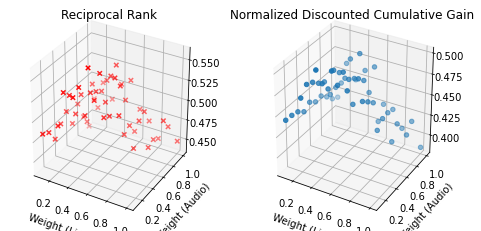

In [ ]:
X = np.array(X)
Y = np.array(Y)
Z1 = np.array(reciprocal_ranks)
Z2 = np.array(nDCGs)

fig = plt.figure(figsize=(8,4))

#First plot
ax = fig.add_subplot(121, projection='3d')

ax.scatter(X,Y,Z1, marker="x", c="red")

ax.set_title("Reciprocal Rank")

ax.set_xlabel("Weight (LightFM)")

ax.set_ylabel("Weight (Audio)")

#Second plot
ax = fig.add_subplot(122, projection='3d')

ax.scatter(xs = X, ys = Y, zs = Z2)

ax.set_title("Normalized Discounted Cumulative Gain")

ax.set_xlabel("Weight (LightFM)")

ax.set_ylabel("Weight (Audio)")

plt.show() 

In [ ]:
print("Best Reciprocal Rank [{}] achieved with ({},{})".format(best_rec_data[0],best_rec_data[1],best_rec_data[2]))
print("Best nDCG [{}] achieved with ({},{})".format(best_nDCG_data[0],best_nDCG_data[1],best_nDCG_data[2]))

Best Reciprocal Rank [0.5567816417191188] achieved with (0.4,0.4)
Best nDCG [0.49850866747073375] achieved with (0.30000000000000004,0.30000000000000004)


In [ ]:
pipiPupuMetadata = MetadataInfo(True, True, None, [[np.copy(movielens_audio_embeddings)]])
pipiPupuRecommender = Recommendation_System(algorithms_constructors, datasets_paths, metric_constructors, fusion_functions)

fs_args = {"weights":[0.3,0.3]}

pipiPupuResults = pipiPupuRecommender.conduct_experiment(algorithm='LightFM',dataset='ML-100K-CUSTOM',folding_strategy=folding_strategy, epochs=30, recommend=True, recommendations_num=30, metadata=pipiPupuMetadata, fusion_order="late", fusion_type="weighted", fusion_arguments=fs_args, no_components=16, loss = 'bpr')
pipiPupuEvaluations = pipiPupuRecommender.evaluate_recommendations(recommendation_results=pipiPupuResults, mute=False)

Recommendation Results
[(     user    item  rating
0       2   89774     5.0
1       2  106782     5.0
2       6      47     4.0
3       6     318     5.0
4       7    5349     3.5
..    ...     ...     ...
893   605    4993     5.0
894   605    1210     5.0
895   605    3000     3.0
896   605    2011     4.0
897   609     318     4.0

[898 rows x 3 columns],         item     score  user  rank Algorithm
4        296  0.403248     2     1   LightFM
82     48780  0.190337     2     2   LightFM
84     89745  0.189797     2     3   LightFM
2         50  0.172705     2     4   LightFM
26      2571  0.099356     2     5   LightFM
...      ...       ...   ...   ...       ...
10492   1214 -0.228752   609    26   LightFM
10550   7153 -0.289529   609    27   LightFM
10586    778 -0.323794   609    28   LightFM
10532     16 -0.366320   609    29   LightFM
10481    527 -0.371000   609    30   LightFM

[5550 rows x 5 columns])]
Tests List
[     user    item  rating
0       2   89774     5.0
1      